In [1]:
from Utils import Utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from keras.layers import Input
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

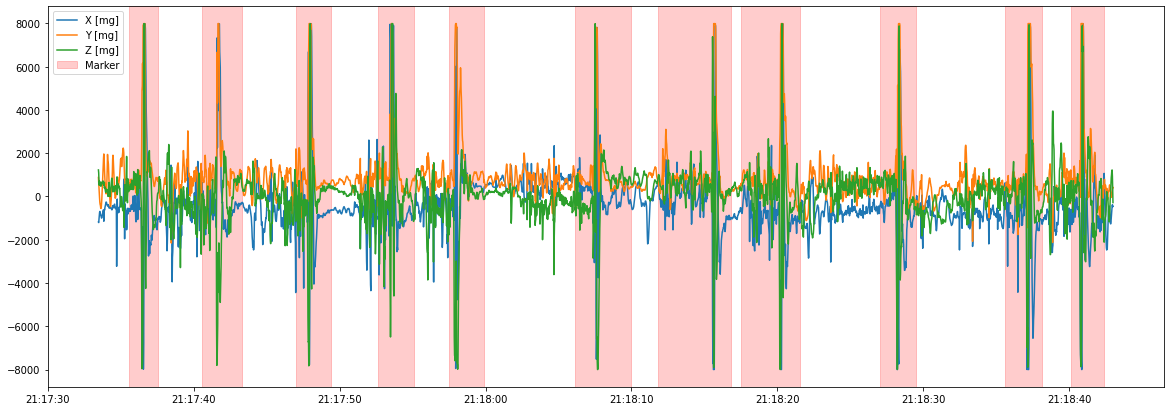

In [2]:
data_shoot_moving = Utils.read_data_csv('DATA_NEW/SHOOT_AVANT.csv')
markers_shoot_moving = Utils.read_markers('DATA_NEW/MARKER_SHOOT_AVANT.csv')
Utils.plot_with_markers(data_shoot_moving,markers_shoot_moving)

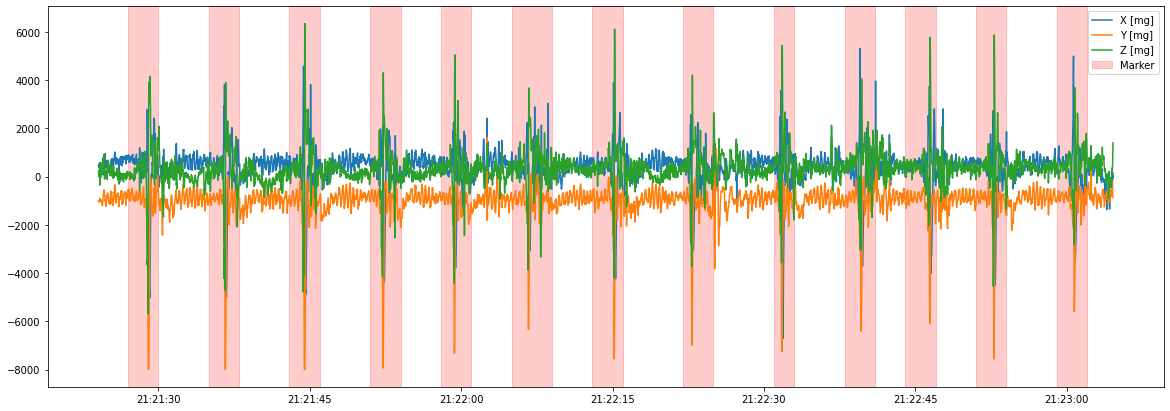

In [3]:
data_pass_moving = Utils.read_data_csv('DATA_NEW/PASSE_AVANT_THOMAS.csv')
markers_pass_moving = Utils.read_markers('DATA_NEW/MARKER_PASS_AVANT.csv')
Utils.plot_with_markers(data_pass_moving,markers_pass_moving)

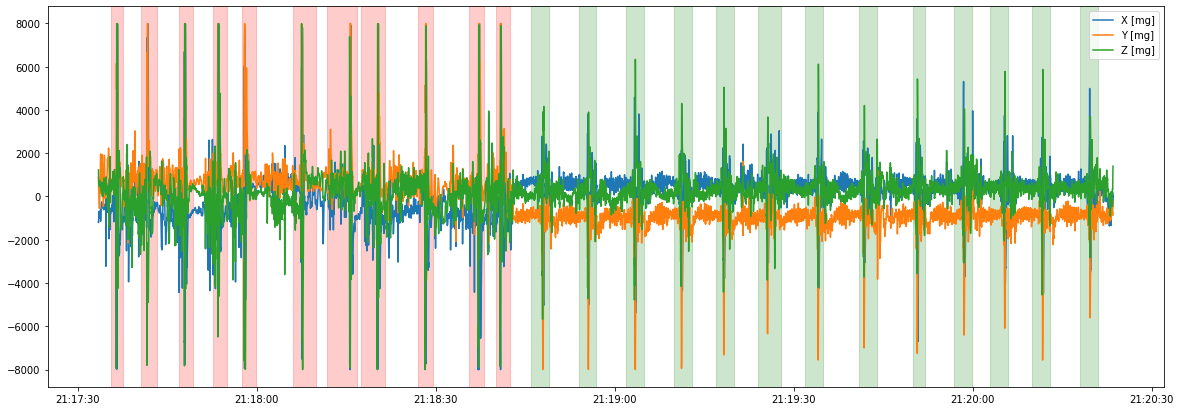

In [4]:
data_moving,markers_moving = data_backend,markers_backend = Utils.concatenate_data(data_shoot_moving.copy(),data_pass_moving.copy(),markers_shoot_moving,markers_pass_moving)
Utils.plot_with_markers_label(data_moving,markers_moving)

In [5]:
freq_sampling=50
markers_timedelta_max=np.max([end-start for (start,end,_) in markers_moving])//(2.8)
window_size=int(markers_timedelta_max.total_seconds()*freq_sampling)
window_size

89

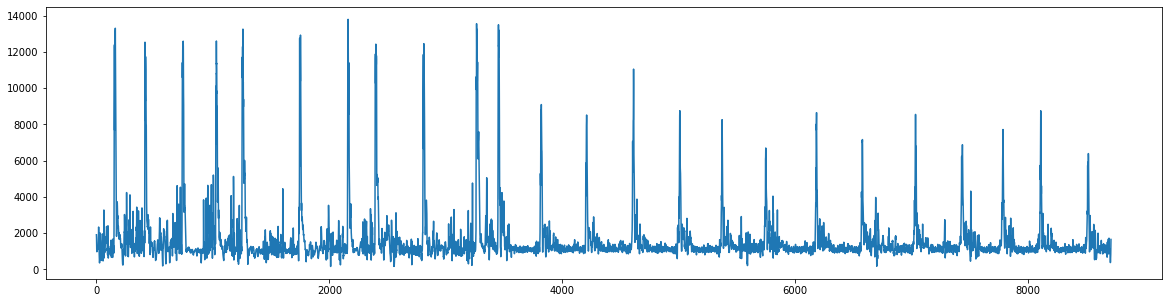

In [6]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(np.linalg.norm(data_moving,axis=1))
plt.show()

In [7]:
y_real = Utils.add_column_classification(data_moving,markers_moving)
y_real.shape

(8712,)

In [8]:
def window_slide(data, y, window_size,n_classes):
    n = len(data)//window_size
    X = np.zeros((n,window_size))
    y_block = np.zeros((n,n_classes)) 
    for i in range(n):
        X[i,:] = np.linalg.norm(data[i*window_size:(i+1)*window_size],axis=1)
        label = int(Utils.get_label(y[i*window_size:(i+1)*window_size]))
        y_block[i,label] = 1
    return X,y_block

In [9]:
n_classes = 3
X,y = window_slide(data_moving, y_real, window_size,n_classes)
print(X.shape)
print(y.shape)

(97, 89)
(97, 3)


In [10]:


model = Sequential()
model.add(Input(shape=(window_size,1),name='input'))
model.add(Conv1D(filters=32,kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=16,kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=8,kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(16,activation='relu'))
model.add(Dense(n_classes,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 89, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 16)            2576      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 16)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 8)              392       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 8)             0

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33)

# Normalize
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(len(X_train),window_size,1)
X_test = X_test.reshape(len(X_test),window_size,1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(64, 89, 1)
(33, 89, 1)
(64, 3)
(33, 3)


In [12]:
batch_size = 8
n_epoch = 50

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, y_train,class_weight={0:1.,1:1.5,2:1.5}, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split=0.2)

Epoch 1/50
7/7 [==============================] - 1s 39ms/step - loss: 1.2426 - accuracy: 0.5686 - val_loss: 1.1680 - val_accuracy: 0.6154
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 1.2249 - accuracy: 0.5882 - val_loss: 1.1297 - val_accuracy: 0.6154
Epoch 3/50
7/7 [==============================] - 0s 7ms/step - loss: 1.2022 - accuracy: 0.6078 - val_loss: 1.1049 - val_accuracy: 0.5385
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 1.1743 - accuracy: 0.5490 - val_loss: 1.1399 - val_accuracy: 0.6154
Epoch 5/50
7/7 [==============================] - 0s 7ms/step - loss: 1.1158 - accuracy: 0.7059 - val_loss: 1.0957 - val_accuracy: 0.6154
Epoch 6/50
7/7 [==============================] - 0s 6ms/step - loss: 1.1054 - accuracy: 0.6667 - val_loss: 1.0637 - val_accuracy: 0.5385
Epoch 7/50
7/7 [==============================] - 0s 5ms/step - loss: 1.1303 - accuracy: 0.6863 - val_loss: 1.0634 - val_accuracy: 0.6154
Epoch 8/50
7/7 [=================

Test score: 0.7772434949874878
Test accuracy: 0.6969696879386902


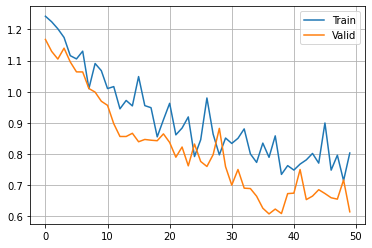

In [13]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.legend()
plt.grid()

score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [14]:
y_pred = model.predict(X_test)

In [15]:
y_pred_label = np.argmax(y_pred,axis=1).astype('int32')
y_pred_label

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1])

In [16]:
y_test_label = np.argmax(y_test,axis=1).astype('int32')
y_test_label

array([0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0,
       0, 1, 2, 0, 0, 2, 0, 2, 0, 0, 1])

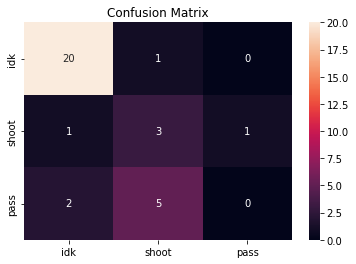

In [17]:
Utils.plot_confusion_matrix(y_test_label,y_pred_label)

In [18]:
print(f'Accuracy with test data : {accuracy_score(y_test_label,y_pred_label)}')

Accuracy with test data : 0.696969696969697


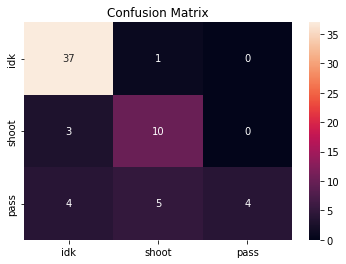

In [19]:
y_pred = model.predict(X_train)

y_pred_label = np.argmax(y_pred,axis=1).astype('int32')

y_train_label = np.argmax(y_train,axis=1).astype('int32')

Utils.plot_confusion_matrix(y_train_label,y_pred_label)

In [20]:
print(f'Accuracy with train data : {accuracy_score(y_train_label,y_pred_label)}')

Accuracy with train data : 0.796875


In [21]:
# LSTM -> stateless
# class_weight
# https://keras.io/keras_tuner/

In [22]:
import keras_tuner as kt
import keras

In [23]:
class MyTunerModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        for _ in range(hp.Int('layers',1,2)):
            model.add(
                Conv1D(
                    hp.Choice('filters',[8,16,32]),
                    hp.Choice('kernel_size',[3,5,7]),
                    padding='same', activation='relu'
                    )
                )
            model.add(MaxPooling1D(hp.Choice('pool_size',[2,3,4])))

        model.add(Flatten())
        
        for _ in range(hp.Int('layers',2,5)):
            model.add(Dense(hp.Choice('units', [8, 16, 32]),activation='relu'))
            
        model.add(Dropout(hp.Choice('rate',[0.3,0.4,0.5,0.6,0.7])))
        
        model.add(Dense(n_classes,activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            class_weight={0:1.,1:1.5,2:1.5},
            **kwargs,
        )

In [33]:
tuner = kt.RandomSearch(
    MyTunerModel(),
    objective='val_loss',
    max_trials=150,
    overwrite=True,
    project_name='unihockey_nn_models')

In [34]:
tuner.search(X_train, y_train,epochs=50,batch_size=8, validation_split=0.2)

Trial 150 Complete [00h 00m 09s]
val_loss: 0.6611581444740295

Best val_loss So Far: 0.48717063665390015
Total elapsed time: 00h 18m 11s
INFO:tensorflow:Oracle triggered exit


In [35]:
best_model = tuner.get_best_models()[0]

In [36]:
best_model.build(input_shape=(None,window_size,1))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 89, 16)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 16)            1808      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 16)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 32)                2

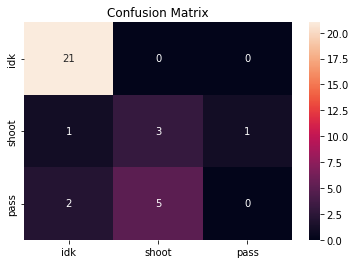

In [37]:
y_pred = best_model.predict(X_test)

y_pred_label = np.argmax(y_pred,axis=1).astype('int32')

y_test_label = np.argmax(y_test,axis=1).astype('int32')

Utils.plot_confusion_matrix(y_test_label,y_pred_label)

In [38]:
print(f'Accuracy with test data : {accuracy_score(y_test_label,y_pred_label)}')

Accuracy with test data : 0.7272727272727273


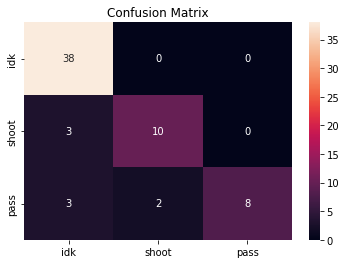

In [39]:
y_pred = best_model.predict(X_train)

y_pred_label = np.argmax(y_pred,axis=1).astype('int32')

y_train_label = np.argmax(y_train,axis=1).astype('int32')

Utils.plot_confusion_matrix(y_train_label,y_pred_label)

In [40]:
print(f'Accuracy with train data : {accuracy_score(y_train_label,y_pred_label)}')

Accuracy with train data : 0.875


In [52]:
best_model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 89, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv1d_input'}},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (7,),
    'strides': (1,),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling1D',
   'config': {'name': 'max_pooling1d',
    'trainable': True,
    'dtype': 'float32',
    'strides': (4,),
    'pool_size': 

In [58]:
res = Utils.create_results_csv(y_pred_label,'res_example.csv')
res
    

{'shoot': 12, 'pass': 8}